In [1]:
import numpy as np
import random
from sklearn import datasets

In [107]:
class Particle:
    def __init__(self, bounds, x_init_type, v_init_type, Nc, x, data, c):
        self.local_best_j = 10000
        self.neigh_best_j = 10000
        self.global_best_j = 10000
        self.local_best = []
        self.neigh_best = []
        self.global_best = []
        self.neigh = []
        self.bounds = bounds
        self.Nc = Nc
        self.x, self.v = self.init_xv(x_init_type, v_init_type, x, data)
        self.c = c
        
    def move(self):
        self.r = [random.uniform(0,1),random.uniform(0,1),1]
        if self.c[2]!=0:
            self.v = self.c[0]*self.v + self.c[1]*self.r[0]*(self.local_best-self.x) + self.c[2]*self.r[1]*(self.neigh_best-self.x) +self.c[3]*self.r[2]*(self.global_best - self.x)
        else:
            self.v = self.c[0]*self.v + self.c[1]*self.r[0]*(self.local_best-self.x) + self.c[3]*self.r[2]*(self.global_best - self.x)
        self.x = self.x + self.v
        
    def init_xv(self,x_init_type, v_init_type, x_kmeans,data):     
        x = []
        v = []
        for j in range(self.Nc):
            temp = []
            for b in self.bounds:
                temp.append(random.uniform(b[0],b[1]))
            x.append(np.array(temp))
            #x.append(data[np.random.choice([i for i in range(len(data))])])
        if x_init_type != "random":
            x = np.copy(x_kmeans)
        if v_init_type == "random":
            for j in range(self.Nc):
                temp = []
                for b in self.bounds:
                    temp.append(random.uniform((b[0]-b[1])/2,(b[1]-b[0])/2))
                v.append(np.array(temp))
        else:
            v = np.zeros((self.Nc,len(self.bounds)))
        return np.array(x),np.array(v)

In [237]:
class PSO:
    def __init__(self,data_x, data_y, particle_count, bound, c, tribe_count, x_init = "random", v_init = "random"):
        self.data_x, self.data_y = data_x, data_y
        index = [i for i in range(particle_count)]
        k_means = self.kmeans(bound, 1000)
        self.particles = [Particle(bound,x_init , v_init ,3,k_means,self.data_x, c) for i in range(particle_count)]
        self.bound = bound
        mem   =  int(particle_count/tribe_count)
        self.tribe_creator(tribe_count,particle_count,mem)
        self.type_x = x_init


    
    def tribe_creator(self,tribe_count,particle_count,mem):
        for i in range(tribe_count):
            self.particles[i*mem].neigh = [i*mem+j for j in range(mem)]
            for k in range(mem-1):
                self.particles[i*mem+k+1].neigh = [i*mem+j for j in range(mem)]
                last = i*mem+k
        for i in range(tribe_count-1):
            self.particles[i*mem].neigh.append(i*mem+mem)
        n = [i+last for i in range(particle_count-last)]
        while last<particle_count:
            self.particles[last].neigh = np.copy(n)
            last = last+1
        for p in self.particles:
            p.neigh = np.array(p.neigh)
        
    def distance(self,z,m):
        return np.sqrt(np.sum((z-m)*(z-m))) 
    
    
    
    def J(self, m, pred):
        j = 0
        classes = [[],[],[]]
        for p in range(len(pred)):
            classes[pred[p]].append(self.data_x[p])
        for c in range(len(m)):
            count = 0
            for z in classes[c]:
                count = count + self.distance(z,m[c])
            if len(classes[c])!=0:
                j = j + count/len(classes[c])
        return j/len(m)
    
    def accuracy(self,global_best):
        '''find which centers is for which class'''
        if self.type_x != "random":
            classes = []
            for x in self.data_x:
                classes.append(np.argmin([self.distance(x,c) for c in global_best]))
            return np.sum([int(y==yp) for (y,yp) in zip(self.data_y,classes)])/len(classes)
        ind = []
        for c in global_best:
            dist = []
            for i in range(3):
                dist.append(np.sum([self.distance(c,x) for x in np.array(self.data_x)[self.data_y==i]]))
            ind.append(np.argmin(dist))
        out = []
        for i in ind:
            out.append(global_best[i])
        '''calculate accuracy'''
        classes = []
        for x in self.data_x:
            classes.append(np.argmin([self.distance(x,c) for c in out]))
        return np.sum([int(y==yp) for (y,yp) in zip(self.data_y,classes)])/len(classes)
    
    
    
    
    def main(self,tmax, fixed_var = True, linear = True):
        '''calculate j'''
        for p in self.particles:
            classes = []
            for x in self.data_x:
                classes.append(np.argmin([self.distance(x,c) for c in p.x]))
            j = self.J(p.x,classes)
            p.local_best_j = j
            p.local_best = np.copy(p.x)
        '''update global best'''
        global_best_j = np.min([p.local_best_j for p in self.particles])
        global_best = self.particles[np.argmin([p.local_best_j for p in self.particles])].local_best
        for p in self.particles:
            p.global_best_j = global_best_j
            p.global_best = global_best
        history = []
        for t in range(tmax):
            temphist = [global_best_j]
            for p in self.particles:
                '''calculate j'''
                classes = []
                for x in self.data_x:
                    classes.append(np.argmin([self.distance(x,c) for c in p.x]))
                j = self.J(p.x,classes)
                
                
                '''update best values'''
                
                if j<global_best_j:
                    global_best_j = j
                    global_best = np.copy(p.x)
                    for p in self.particles:
                        p.global_best_j = global_best_j
                        p.global_best = global_best
                
                
                
                if j < p.local_best_j:
                    p.local_best_j = j
                    p.local_best = np.copy(p.x)
                    
                
                '''if neighbours best is used particle position update o.w. save time'''
                if p.c[2]!=0 :    
                    n = np.argmin([self.particles[n].local_best_j for n in p.neigh])
                    if j < p.neigh_best_j:
                        if self.particles[n].local_best_j < j:
                            p.neigh_best_j = self.particles[n].local_best_j
                            p.neigh_best = self.particles[n].local_best
                        else:
                            p.neigh_best_j = j
                            p.neigh_best = np.copy(p.x)
                    for n in p.neigh:
                        self.particles[n].neigh_best_j = p.neigh_best_j
                        self.particles[n].neigh_best = np.copy(p.neigh_best)
                
                '''update inertia weight'''
                if not fixed_var:
                    if not linear:
                        p.c[0] = p.c[0] * tmax / (tmax-t)
                        #c[0] = c[0]* np.exp(t) / np.exp(tmax)
                    if linear:
                        p.c[0] = 2 * p.c[0]* t / tmax
                        #c[0] = c[0] * (1-t/tmax)
                
                '''move particle'''
                p.move()
                '''for x in p.x:
                    for j in range(len(x)):
                        if x[j] > self.bound[j][1]:
                            x[j]=self.bound[j][1]
                        if x[j] < self.bound[j][0]:
                            x[j]=self.bound[j][0]'''
                temphist.append(global_best_j)
            '''update global best history'''
            history.append(np.mean(temphist)) 
        print("ACC:")
        print(self.accuracy(global_best))
        return history, self.accuracy(global_best)
            
    def kmeans(self, bounds, it):
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=3).fit(self.data_x,self.data_y)
        ind = []
        for c in kmeans.cluster_centers_:
            dist = [self.distance(c,x) for x in self.data_x]
            values, counts = np.unique(np.array(self.data_y)[np.argsort(np.array(dist))[:10]], return_counts=True)
            ind.append(values[np.argmax(counts)])
        out = []
        for i in ind:
            out.append(kmeans.cluster_centers_[i])
        return np.array(out)

In [200]:
np.sum(np.array([[1,2],[1,3]])==np.array([[1,2],[1,3]]))

4

In [4]:
iris              = datasets.load_iris()
class_names       = iris.target_names  
y = iris.target
x = iris.data
_, C = np.unique(y, return_counts=True) 
bound = [[np.min(x[:,i]),np.max(x[:,i])] for i in range(len(x[0]))]

Random Vs Kmeans / Random Vs Zero

In [189]:
history = []
acc = []
for i in range(10):
    pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"random","random")
    h, a = pso.main(1000)
    acc.append(a)
    history.append(h)

ACC:
0.3333333333333333
ACC:
0.3333333333333333
ACC:
0.6466666666666666
ACC:
0.3333333333333333
ACC:
0.4866666666666667
ACC:
0.3333333333333333
ACC:
0.66
ACC:
0.6666666666666666
ACC:
0.3466666666666667
ACC:
0.3333333333333333


In [190]:
r_r_s , a = np.mean(history,axis = 0), np.mean(acc)

In [191]:
a

0.44733333333333325

In [192]:
history = []
acc = []
for i in range(10):
    pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"random","zero")
    h, a = pso.main(1000)
    acc.append(a)
    history.append(h)

ACC:
0.3333333333333333
ACC:
0.3333333333333333
ACC:
0.6466666666666666
ACC:
0.3333333333333333
ACC:
0.66
ACC:
0.66
ACC:
0.3333333333333333
ACC:
0.6333333333333333
ACC:
0.22
ACC:
0.3333333333333333


In [193]:
r_z_s , a = np.mean(history,axis = 0), np.mean(acc)

In [194]:
a

0.44866666666666666

In [216]:
pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"kmeans","random")
k_r_s , a = pso.main(1000)

ACC:
0.8933333333333333


In [217]:
pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"kmeans","zero")
k_z_s , a = pso.main(1000)

ACC:
0.8933333333333333


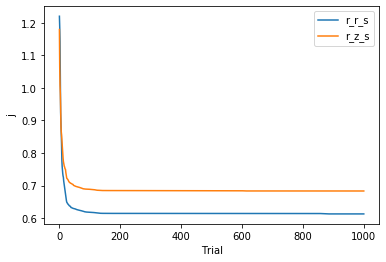

In [229]:
import matplotlib.pyplot as plt
plt.ylabel("j")
plt.xlabel("Trial")
plt.plot([i+1 for i in range(1000)], r_r_s, label = str("random"))
plt.plot([i+1 for i in range(1000)], r_z_s, label = str("zero"))
plt.legend()
plt.show()

Dynamic Vs Static

In [238]:
history = []
acc = []
for i in range(10):
    pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"random","random")
    h, a = pso.main(1000,False)
    acc.append(a)
    history.append(h)

ACC:
0.66
ACC:
0.64
ACC:
0.3333333333333333
ACC:
0.3333333333333333
ACC:
0.6066666666666667
ACC:
0.006666666666666667
ACC:
0.6666666666666666
ACC:
0.3333333333333333
ACC:
0.3333333333333333
ACC:
0.006666666666666667


In [239]:
r_r_d_linear , a = np.mean(history,axis = 0), np.mean(acc)

In [240]:
a

0.392

In [ ]:
history = []
acc = []
for i in range(10):
    pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"random","random")
    h, a = pso.main(1000,False,False)
    acc.append(a)
    history.append(h)

In [223]:
r_r_d_nonlinear , a = np.mean(history,axis = 0), np.mean(acc)

In [224]:
a

0.49466666666666664

In [241]:
history = []
acc = []
for i in range(10):
    pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"random","zero")
    h, a = pso.main(1000,False)
    acc.append(a)
    history.append(h)

ACC:
0.6666666666666666
ACC:
0.66
ACC:
0.22666666666666666
ACC:
0.3333333333333333
ACC:
0.3333333333333333
ACC:
0.18666666666666668
ACC:
0.3333333333333333
ACC:
0.6666666666666666
ACC:
0.6666666666666666
ACC:
0.43333333333333335


In [242]:
r_z_d_linear , a = np.mean(history,axis = 0), np.mean(acc)

In [243]:
a

0.45066666666666666

In [ ]:
history = []
acc = []
for i in range(10):
    pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"random","zero")
    h, a = pso.main(1000,False,False)
    acc.append(a)
    history.append(h)

In [245]:
r_z_d_nonlinear , a = np.mean(history,axis = 0), np.mean(acc)

In [246]:
a

0.382

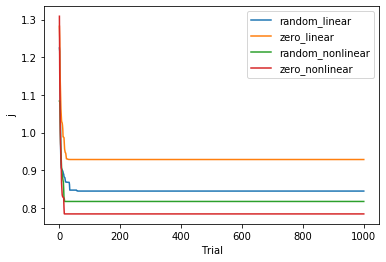

In [251]:
import matplotlib.pyplot as plt
plt.ylabel("j")
plt.xlabel("Trial")
plt.plot([i+1 for i in range(1000)], r_r_d_linear, label = str("random_linear"))
plt.plot([i+1 for i in range(1000)], r_z_d_linear, label = str("zero_linear"))
plt.plot([i+1 for i in range(1000)], r_r_d_nonlinear, label = str("random_nonlinear"))
plt.plot([i+1 for i in range(1000)], r_z_d_nonlinear, label = str("zero_nonlinear"))
plt.legend()
plt.show()

In [249]:
pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"kmeans","zero")
k_z_s , a = pso.main(1000, False, False)

C:\Users\banafshVBTS\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


ACC:
0.8933333333333333


In [250]:
pso = PSO(x,y,10,bound,[0.72,1.49,0,1.49],3,"kmeans","zero")
k_z_s , a = pso.main(1000, False)

ACC:
0.8933333333333333
